# Univariate and Decoding Analyses wrapper. 
This notebook aggregates the results from individual sessions (or computes them- if not previoulsy run). It further has the code to analyse the data at the group level including plots. 

These analyses include various univariate analyses and decoding analyses, all focused on differeiating Left vs Right coding as a function of the cue or the decision.

author: ag
last updated: 9/24/19

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import sys, os, time, json
from pathlib import Path
import pickle as pkl

sys.path.append('../PreProcessing/')
sys.path.append('../Lib/')
sys.path.append('../Analyses/')

import analyses_table as AT
import stem_branch_analyses as SBA
from importlib import reload  # Python 3.4+ only.

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
oakPaths = AT.getOakPaths()

sns.set(style="whitegrid",font_scale=1,rc={
    'axes.spines.bottom': False,
'axes.spines.left': False,
'axes.spines.right': False,
'axes.spines.top': False,
'axes.edgecolor':'0.5'})


load data 

In [5]:
fn = oakPaths['Analyses'] / 'SBA_All_Uni.csv'
All_UniRes = pd.read_csv(fn,index_col=0)

fn = oakPaths['Analyses'] / 'SBA_All_Dec.csv'
All_DecRes  = pd.read_csv(fn,index_col=0)

fn = oakPaths['Analyses'] / 'SBA_All_PopDec.csv'
All_PopDecRes = pd.read_csv(fn,index_col=0)

fn = oakPaths['Analyses'] / 'SBA_All_PopSumDec.csv'
All_PopSumDecRes = pd.read_csv(fn,index_col=0)

# behavioral
All_BehDat = pd.read_csv(oakPaths['Analyses'] / 'TaskBehavior.csv',index_col=0)
All_BehDat = All_BehDat.set_index('se')

or run code below to create data structs.

In [13]:
AT = reload(AT)
SBA = reload(SBA)

task = 'T3g'

animals = ['Li','Ne','Cl']
overwrite=False
doPlots = False

All_UniRes = pd.DataFrame()
All_DecRes = pd.DataFrame()
All_PopDecRes = pd.DataFrame()
for animal in animals:
    
    fn = oakPaths['Root'] / (animal+'_SessionPaths.pkl')
    with fn.open(mode="rb") as f:
        sePaths = pkl.load(f)

    CT_Path =  oakPaths['Clustered'] / animal / (animal+'_ClusteringSummary.json')
    CueDesDat_Fn = oakPaths['Analyses'] / animal / ('{}_{}_CueDesSegRes.csv').format(animal,task)
    CueDesDecDat_Fn = oakPaths['Analyses'] / animal / ('{}_{}_CueDesSegDecRes.csv').format(animal,task)
    CueDesPopDecDat_Fn = oakPaths['Analyses'] / animal / ('{}_{}_CueDesSegDecPopRes.csv').format(animal,task)
    with CT_Path.open() as f:
        CT = json.load(f)
    
    SessionList = []
    cnt=0
    uniRes = pd.DataFrame()
    decRes = pd.DataFrame()
    popDecRes = pd.DataFrame()
    for se,v in CT['Sessions'].items():
        if v:
            temp = se.split('_')
            if temp[1]==task:
                try:
                    print('Analysing Session {}'.format(se))
                    SessionList.append(se)
                    x, _, y, z = SBA.main(sePaths[se],overwrite=overwrite,doPlots=doPlots)
                    x['se'] = se
                    y['se'] = se
                    z['se'] = se
                    if isinstance(x,pd.DataFrame):
                        uniRes = pd.concat((uniRes,x))
                        decRes = pd.concat((decRes,y))
                        popDecRes = pd.concat((popDecRes,z))
                except KeyboardInterrupt:
                    break
                except:
                    print("Error processing session: {}".format(se))
                    print ("Error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)

    uniRes.to_csv(CueDesDat_Fn)
    decRes.to_csv(CueDesDecDat_Fn)
    popDecRes.to_csv(CueDesPopDecDat_Fn)
    
    uniRes['an'] = animal
    decRes['an'] = animal
    popDecRes['an'] = animal
    
    All_UniRes = pd.concat((All_UniRes,uniRes))
    All_DecRes = pd.concat((All_DecRes,decRes))
    All_PopDecRes = pd.concat((All_PopDecRes,popDecRes))

   


Analysing Session Li_T3g_052818
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_052918
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_053018
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_053118
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_060118
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_060418
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_061318
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_061518
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_061818
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_062018
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_062518
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_062618
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_062718
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_062818
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_070218
Loading Beh Trac

Add behavioral session data to the neural data tables. 

In [202]:
 # behavioral
All_BehDat = pd.read_csv(oakPaths['Analyses'] / 'TaskBehavior.csv',index_col=0)
All_BehDat = All_BehDat.set_index('se')

def addBehToDF(dat,beh):
X = dat.copy()
try:
    X = X.reset_index()
except:
    pass
X['nTrials'] = 0
X['pCo'] = 0
X['pCoST'] = 0
for se in beh.index:
    subset = X['se'] == se
    X.loc[subset,'nTrials'] = beh.loc[se,'nTrials']
    X.loc[subset,'pCo'] = beh.loc[se,'pCo']
    X.loc[subset,'pCoST'] = beh.loc[se,'pCoST']
return X


def addUnitID(dat):
    unitCnt = 0
    dat['uID'] = 0
    for se in dat['se'].unique():
        subset = dat['se']==se
        nSeUnits = dat[subset]['unit'].max()+1
        for unit in np.arange(nSeUnits):
            sub2 = subset & (dat['unit']==unit)
            dat.loc[sub2,'uID'] = unitCnt
            unitCnt+=1
    return dat

All_UniRes=addBehToDF(All_UniRes,All_BehDat)
All_DecRes=addBehToDF(All_DecRes,All_BehDat)
All_UniRes=addUnitID(All_UniRes)
All_DecRes=addUnitID(All_DecRes)

X = All_PopDecRes.groupby(['Loc','Test','Decoder','se','an']).mean()
X = X.reset_index()
X['Test'] = pd.Categorical(X['Test'],categories=['Model','Cue','Desc'],ordered=True)
X.sort_values('Test',inplace=True)
X['Loc'] = pd.Categorical(X['Loc'],categories=['h','a','center','be','int','cdfg','goal'],ordered=True)
X.sort_values('Loc',inplace=True)

All_PopSumDecRes = X
All_PopSumDecRes=addBehToDF(All_PopSumDecRes,All_BehDat)

save data

In [29]:
fn = oakPaths['Analyses'] / 'SBA_All_Uni.csv'
All_UniRes.to_csv(fn)
fn = oakPaths['Analyses'] / 'SBA_All_Dec.csv'
All_DecRes.to_csv(fn)
fn = oakPaths['Analyses'] / 'SBA_All_PopDec.csv'
All_PopDecRes.to_csv(fn)
fn = oakPaths['Analyses'] / 'SBA_All_PopSumDec.csv'
All_PopSumDecRes.to_csv(fn)

### Auxiliary imports and function defs.

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib_venn import venn2,venn3

def getSig(pvals):
    
    n = len(pvals)
    s = ['']*n
    cnt=0
    for p in pvals:
        if p<0.001:
            s[cnt] = '***'
        elif p<0.01:
            s[cnt] = '**'
        elif p<0.05:
            s[cnt] ='*'
        elif p<0.1:
            s[cnt] ='~'
        else:
            s[cnt] =''
        cnt+=1
    return s

## I. First Analyses. Cue Coding.

number of units showing A coding in segment Cue: 87 / 930 = 0.094
number of units showing Stem coding in segment Cue: 118 / 930 = 0.127
number of units showing Arm coding in segment Cue: 337 / 930 = 0.362


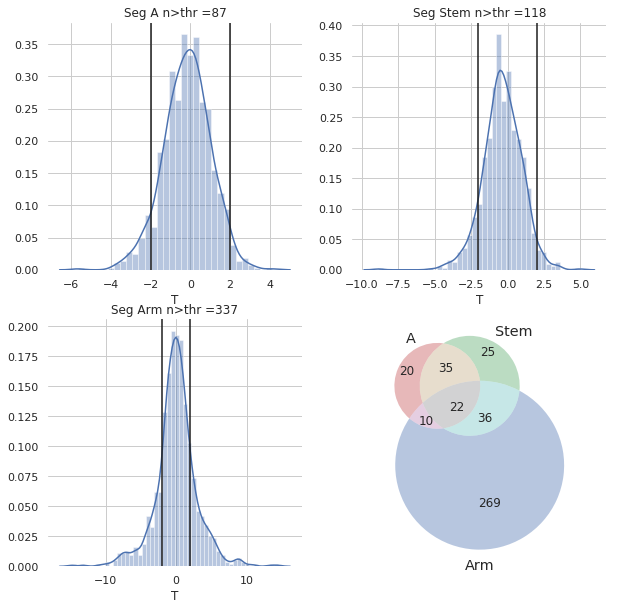

In [546]:
Segs =  ['A','Stem','Arm']
c = 'Cue'

UniCellSets = {}
UniCellSets[c] = {}
f,ax = plt.subplots(2,2,figsize=(10,10))
ax=ax.flatten()
cnt=0
for s in Segs:
    subset = (All_UniRes['Seg']==s) & (All_UniRes['Cond']==c) 

    ax[cnt]=sns.distplot(All_UniRes[subset]['T'],ax=ax[cnt])

    thr = 2
    ax[cnt].axvline(-thr,color='k')
    ax[cnt].axvline(thr,color='k')
    x=np.abs(All_UniRes[subset]['T'])>thr
    UniCellSets[c][s] = set(All_UniRes[subset]['uID'][x].values)
    ax[cnt].set_title('Seg ' + s +' n>thr ='+str(np.sum(x)))
    
    print( 'number of units showing {0} coding in segment {1}: {2} / {3} = {4:.3f}'.format(s,c,np.sum(x),len(x),np.mean(x)))
    cnt+=1
    
plt.sca(ax[3])
_=venn3([ UniCellSets[c]['A'], UniCellSets[c]['Stem'], UniCellSets[c]['Arm']],set_labels=Segs)


## II. Dec Analyses:

number of units showing A coding in segment Desc: 85 / 930 = 0.091
number of units showing Stem coding in segment Desc: 123 / 930 = 0.132
number of units showing Arm coding in segment Desc: 466 / 930 = 0.501


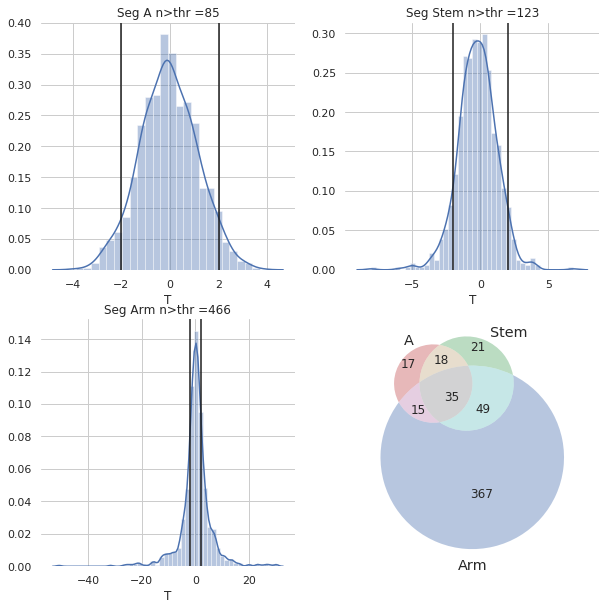

In [547]:
Segs =  ['A','Stem','Arm']
c = 'Desc'

UniCellSets[c] = {}
f,ax = plt.subplots(2,2,figsize=(10,10))
ax=ax.flatten()
cnt=0
for s in Segs:
    subset = (All_UniRes['Seg']==s) & (All_UniRes['Cond']==c) 

    ax[cnt]=sns.distplot(All_UniRes[subset]['T'],ax=ax[cnt])

    thr = 2
    ax[cnt].axvline(-thr,color='k')
    ax[cnt].axvline(thr,color='k')
    x=np.abs(All_UniRes[subset]['T'])>thr
    UniCellSets[c][s] = set(All_UniRes[subset]['uID'][x].values)
    ax[cnt].set_title('Seg ' + s +' n>thr ='+str(np.sum(x)))
    
    print( 'number of units showing {0} coding in segment {1}: {2} / {3} = {4:.3f}'.format(s,c,np.sum(x),len(x),np.mean(x)))
    cnt+=1
    
plt.sca(ax[3])
_=venn3([UniCellSets[c]['A'],UniCellSets[c]['Stem'],UniCellSets[c]['Arm']],set_labels=Segs)

## III. Cue/Dec overlap.

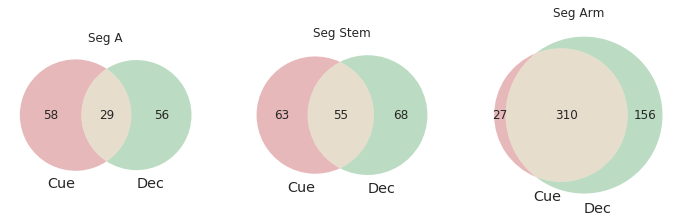

In [45]:
f,ax = plt.subplots(1,3,figsize=(12,4))
ax=ax.flatten()
cnt=0
for s in Segs:
    plt.sca(ax[cnt])
    _ = venn2([CellSets['Cue'][s],CellSets['Desc'][s]],set_labels=['Cue','Dec'])
    ax[cnt].set_title('Seg ' + s )
    cnt+=1


number of units showing Co_Arm coding in segment Cue_Desc: 446 / 930 = 0.480
number of units showing L_Arm coding in segment Cue_Desc: 94 / 930 = 0.101
number of units showing R_Arm coding in segment Cue_Desc: 73 / 930 = 0.078


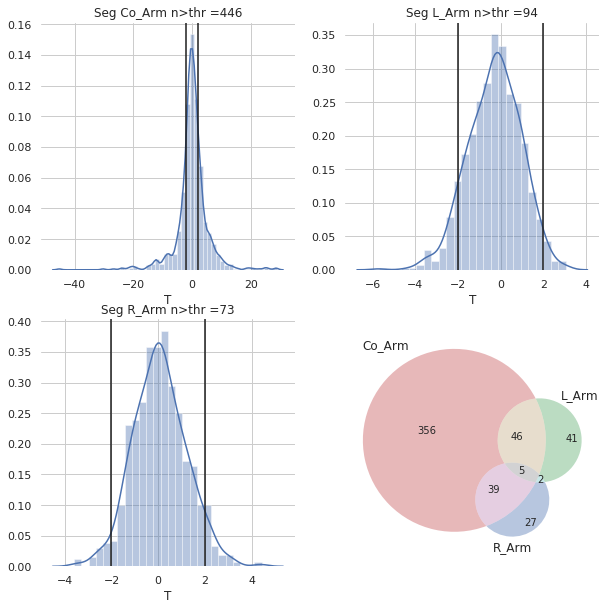

In [42]:
Segs =  ['Co_Arm','L_Arm','R_Arm']
c = 'Cue_Desc'

CellSets[c] = {}
f,ax = plt.subplots(2,2,figsize=(10,10))
ax=ax.flatten()
cnt=0
for s in Segs:
    subset = (All_UniRes['Seg']==s) & (All_UniRes['Cond']==c) 

    ax[cnt]=sns.distplot(All_UniRes[subset]['T'].dropna(),ax=ax[cnt])

    thr = 2
    ax[cnt].axvline(-thr,color='k')
    ax[cnt].axvline(thr,color='k')
    x=np.abs(All_UniRes[subset]['T'])>thr
    CellSets[c][s] = set(All_UniRes[subset]['uID'][x].values)
    ax[cnt].set_title('Seg ' + s +' n>thr ='+str(np.sum(x)))
    
    print( 'number of units showing {0} coding in segment {1}: {2} / {3} = {4:.3f}'.format(s,c,np.sum(x),len(x),np.mean(x)))
    cnt+=1
    
plt.sca(ax[3])
_=venn3([CellSets[c][Segs[0]],CellSets[c][Segs[1]],CellSets[c][Segs[2]]],set_labels=Segs)

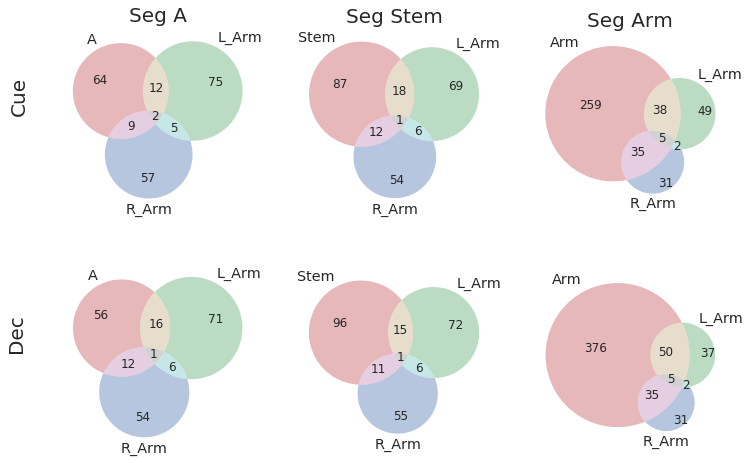

In [46]:
f,ax = plt.subplots(2,3,figsize=(12,8))

Segs = ['A','Stem','Arm']
Conds = ['Cue','Desc']
ii=0
for c in Conds:
    jj = 0
    for s in Segs:
        plt.sca(ax[ii,jj])
        _=venn3([CellSets[c][s],CellSets['Cue_Desc']['L_Arm'],CellSets['Cue_Desc']['R_Arm'] ],set_labels=[s,'L_Arm','R_Arm'])
        if ii==0:
            ax[ii,jj].set_title('Seg ' + s,fontsize=20)
        jj+=1
    ii+=1
_=ax[0,0].text(-1,0.1,'Cue',fontsize=20,rotation='vertical',verticalalignment='center',horizontalalignment='center')
_=ax[1,0].text(-1,0.1,'Dec',fontsize=20,rotation='vertical',verticalalignment='center',horizontalalignment='center')


## IV. Behavior to activity analyses. 
1) is the extent to which the cue is represented at the different parts of the maze indicative of performance?

In [9]:
import statsmodels.formula.api as smf

tol = 0.001
f = lambda x: np.log( (x+tol) /(1- (x+tol)))
All_UniRes['aT'] = np.abs(All_UniRes['T'])
All_UniRes['L_pCo'] =  f(All_UniRes['pCo'])

mdf = {}
for c in ['Cue','Desc','Cue_Desc']:
    subset = (All_UniRes['Cond']==c)

    dat =[]
    dat = All_UniRes[subset]
    dat = dat[~dat['T'].isnull()]

    md =smf.mixedlm('L_pCo ~ Seg:aT',data=dat,groups=dat['an'])
    mdf[c] = md.fit()
    print(mdf[c].summary())
    print(mdf[c].wald_test_terms())
    print()

subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_UniRes[subset]
dat = dat[~dat['T'].isnull()]
md =smf.mixedlm('L_pCo ~ Seg:aT * Cond',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())
print()

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: L_pCo     
No. Observations: 2790    Method:             REML      
No. Groups:       3       Scale:              0.1628    
Min. group size:  558     Likelihood:         -1445.3623
Max. group size:  1410    Converged:          Yes       
Mean group size:  930.0                                 
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.467    0.111 13.250 0.000  1.250  1.684
Seg[A]:aT      0.043    0.013  3.242 0.001  0.017  0.069
Seg[Arm]:aT    0.033    0.005  6.340 0.000  0.023  0.043
Seg[Stem]:aT   0.042    0.012  3.566 0.000  0.019  0.065
Group Var      0.036    0.091                           

                 chi2                  P>chi2  df constraint
Intercept  175.567503   4.500696308521924e-40              1
Seg:aT      44.408894  1.2355916

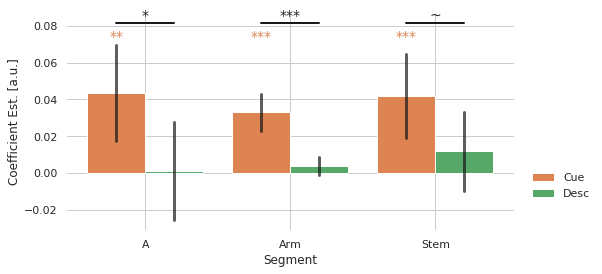

In [12]:
cols = sns.color_palette()[1:3]

m = np.zeros((2,3))
m[0] = mdf['Cue'].params[1:4]
m[1] = mdf['Desc'].params[1:4]

ci = np.zeros((2,3,2))
ci[0] = mdf['Cue'].conf_int()[1:4]
ci[1] = mdf['Desc'].conf_int()[1:4]

f,ax = plt.subplots(1,figsize=(8,4))
x = np.arange(3)
wi=0.4
ax.bar(x-wi/2,m[0],wi,label='Cue',color=cols[0])
ax.bar(x+wi/2,m[1],wi,label='Desc',color=cols[1])
ax.set_xticks(x)
ax.set_xticklabels(['A','Arm','Stem'])

for ii in x:
    ax.plot([ii-wi/2,ii-wi/2],ci[0][ii],linewidth=3,color='k',alpha=0.7)
    ax.plot([ii+wi/2,ii+wi/2],ci[1][ii],linewidth=3,color='k',alpha=0.7)

s = {}
s[0] = getSig(mdf['Cue'].pvalues[1:4])
s[1] = getSig(mdf['Desc'].pvalues[1:4])
s[2] = getSig(mdf['x'].pvalues[5:8])


yup = ax.get_ylim()[1]
for ii in x:
    ax.text(ii-wi/2,yup*1.05,s[0][ii],fontsize=14, horizontalalignment='center', verticalalignment='top',color=cols[0])
    ax.text(ii+wi/2,yup*1.05,s[1][ii],fontsize=14, horizontalalignment='center', verticalalignment='top',color=cols[1])
    if not(s[2][ii]==''):
        ax.plot([ii-wi/2,ii+wi/2],[yup*1.1,yup*1.1],linewidth=2,color='k')
        ax.text(ii,yup*1.1,s[2][ii],fontsize=14,horizontalalignment='center', verticalalignment='bottom')
        
    
ax.set_xlabel('Segment')
ax.set_ylabel('Coefficient Est. [a.u.]')

_=ax.legend(bbox_to_anchor=(1.02,0.1),loc=3,frameon=False)


In [13]:

f = lambda x: np.log( (x+tol) /(1- (x+tol)))
All_UniRes['L_pCoST'] =  f(All_UniRes['pCoST'])

mdf = {}
for c in ['Cue','Desc','Cue_Desc']:
    subset = (All_UniRes['Cond']==c)

    dat =[]
    dat = All_UniRes[subset].copy()
    dat = dat[~ ( (dat['T'].isnull()) | (dat['L_pCoST'].isnull () ) )]

    md =smf.mixedlm('L_pCoST ~ Seg:aT',data=dat,groups=dat['an'])
    mdf[c] = md.fit()
    print(mdf[c].summary())
    print(mdf[c].wald_test_terms())
    print()

subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_UniRes[subset].copy()
dat = dat[~ ( (dat['T'].isnull()) | (dat['L_pCoST'].isnull () ) )]
md =smf.mixedlm('L_pCoST ~ Seg:aT * Cond',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())
print()

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: L_pCoST   
No. Observations: 2712    Method:             REML      
No. Groups:       3       Scale:              0.2864    
Min. group size:  525     Likelihood:         -2171.4589
Max. group size:  1410    Converged:          Yes       
Mean group size:  904.0                                 
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       1.907    0.277 6.894 0.000  1.365  2.449
Seg[A]:aT       0.053    0.018 2.969 0.003  0.018  0.088
Seg[Arm]:aT     0.040    0.007 5.706 0.000  0.026  0.053
Seg[Stem]:aT    0.044    0.016 2.811 0.005  0.013  0.074
Group Var       0.229    0.431                          

                chi2                 P>chi2  df constraint
Intercept  47.529628  5.417886694196926e-12              1
Seg:aT     35.125163  1.146282706833

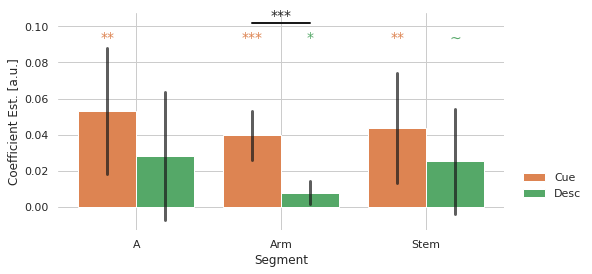

In [14]:
cols = sns.color_palette()[1:3]

m = np.zeros((2,3))
m[0] = mdf['Cue'].params[1:4]
m[1] = mdf['Desc'].params[1:4]

ci = np.zeros((2,3,2))
ci[0] = mdf['Cue'].conf_int()[1:4]
ci[1] = mdf['Desc'].conf_int()[1:4]

f,ax = plt.subplots(1,figsize=(8,4))
x = np.arange(3)
wi=0.4
ax.bar(x-wi/2,m[0],wi,label='Cue',color=cols[0])
ax.bar(x+wi/2,m[1],wi,label='Desc',color=cols[1])
ax.set_xticks(x)
ax.set_xticklabels(['A','Arm','Stem'])

for ii in x:
    ax.plot([ii-wi/2,ii-wi/2],ci[0][ii],linewidth=3,color='k',alpha=0.7)
    ax.plot([ii+wi/2,ii+wi/2],ci[1][ii],linewidth=3,color='k',alpha=0.7)

s = {}
s[0] = getSig(mdf['Cue'].pvalues[1:4])
s[1] = getSig(mdf['Desc'].pvalues[1:4])
s[2] = getSig(mdf['x'].pvalues[5:8])


yup = ax.get_ylim()[1]
for ii in x:
    ax.text(ii-wi/2,yup*1.05,s[0][ii],fontsize=14, horizontalalignment='center', verticalalignment='top',color=cols[0])
    ax.text(ii+wi/2,yup*1.05,s[1][ii],fontsize=14, horizontalalignment='center', verticalalignment='top',color=cols[1])
    if not(s[2][ii]==''):
        ax.plot([ii-wi/2,ii+wi/2],[yup*1.1,yup*1.1],linewidth=2,color='k')
        ax.text(ii,yup*1.1,s[2][ii],fontsize=14,horizontalalignment='center', verticalalignment='bottom')
        
    
ax.set_xlabel('Segment')
ax.set_ylabel('Coefficient Est. [a.u.]')

_=ax.legend(bbox_to_anchor=(1.02,0.1),loc=3,frameon=False)


Plot all the data by cell and animal.

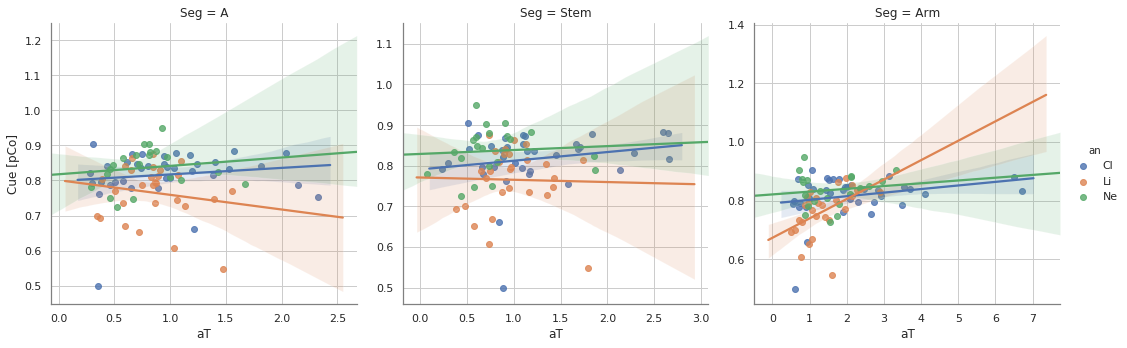

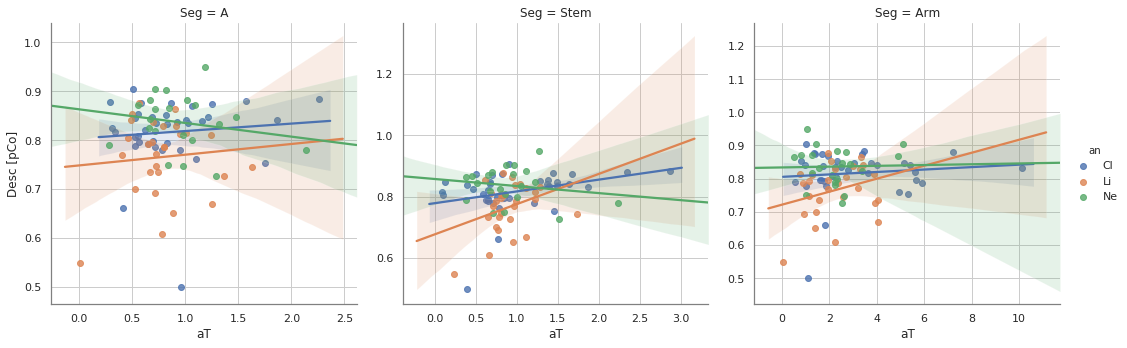

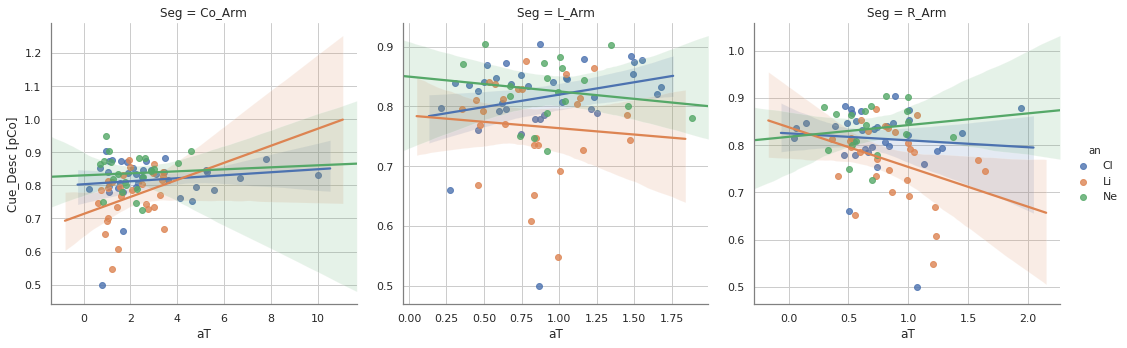

In [15]:
X=All_UniRes.groupby(['se','an','Seg','Cond']).median()
X=X.reset_index()

for c  in ['Cue','Desc']:
    subset = (X['Cond']==c)
    ax=sns.lmplot(x='aT',y='pCo',hue='an',col='Seg',data=X[subset],col_order=['A','Stem','Arm'],sharex=False,sharey=False)
    ax.set_ylabels(c + ' [pCo]')
    
subset = (X['Cond']=='Cue_Desc')
ax=sns.lmplot(x='aT',y='pCo',hue='an',col='Seg',data=X[subset],col_order=['Co_Arm','L_Arm','R_Arm'],sharex=False,sharey=False)
ax.set_ylabels('Cue_Desc' + ' [pCo]')

## Decoding Results.

## I. Decoding Results by Cell. 

In [109]:
relevant_vars = ['Loc','Test','unit','Decoder','BAc','P','Z','-log(P)','se','an','nTrials', 'pCo', 'pCoST', 'uID']
X = All_DecRes[relevant_vars].copy()
X.groupby(['Test','Loc','Decoder','an','se']).mean()
X=X.reset_index()
X['Test'] = pd.Categorical(X['Test'],categories=['Model','Cue','Desc'],ordered=True)
X.sort_values('Test',inplace=True)
X['Loc'] = pd.Categorical(X['Loc'],categories=['h','a','center','be','int','cdfg','goal'],ordered=True)
X.sort_values('Loc',inplace=True)

X.loc[X['Z']>10,'Z']=10
X.loc[X['Z']<-10,'Z']=-10

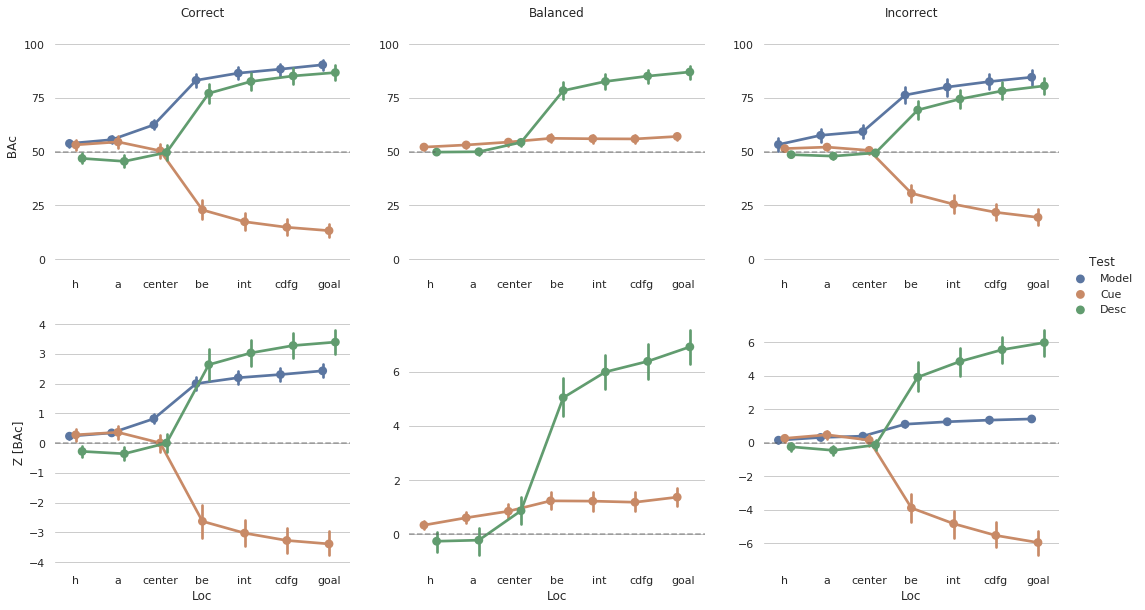

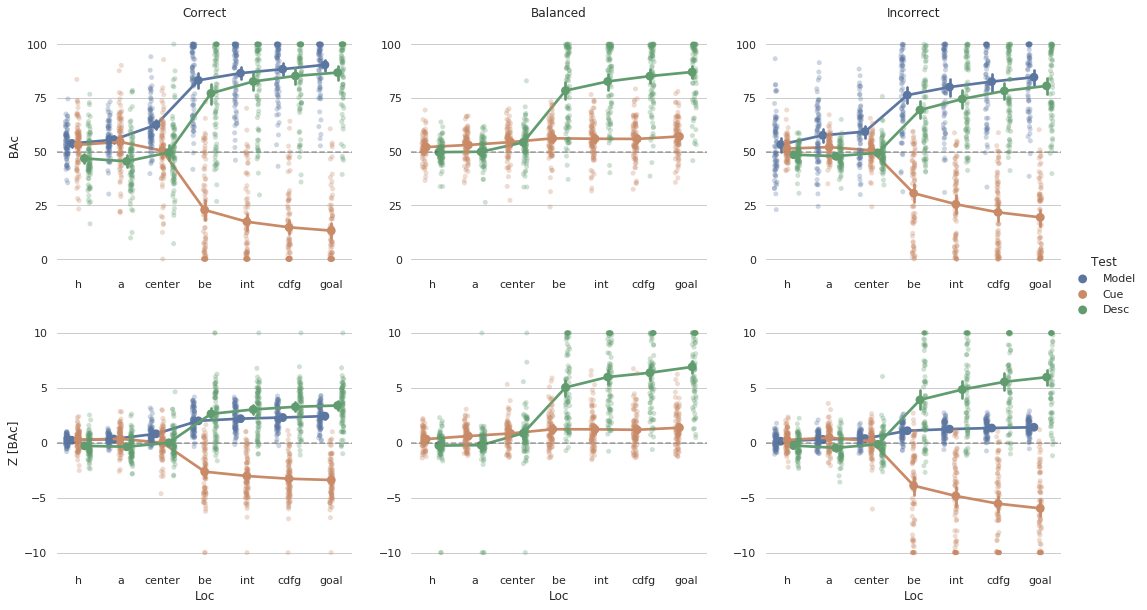

In [118]:
_=SBA.plotMultipleDecoderResults(X,plotAll=False,ci=95)
_=SBA.plotMultipleDecoderResults(X,plotAll=True,ci=95)

## II. Population decoding results.

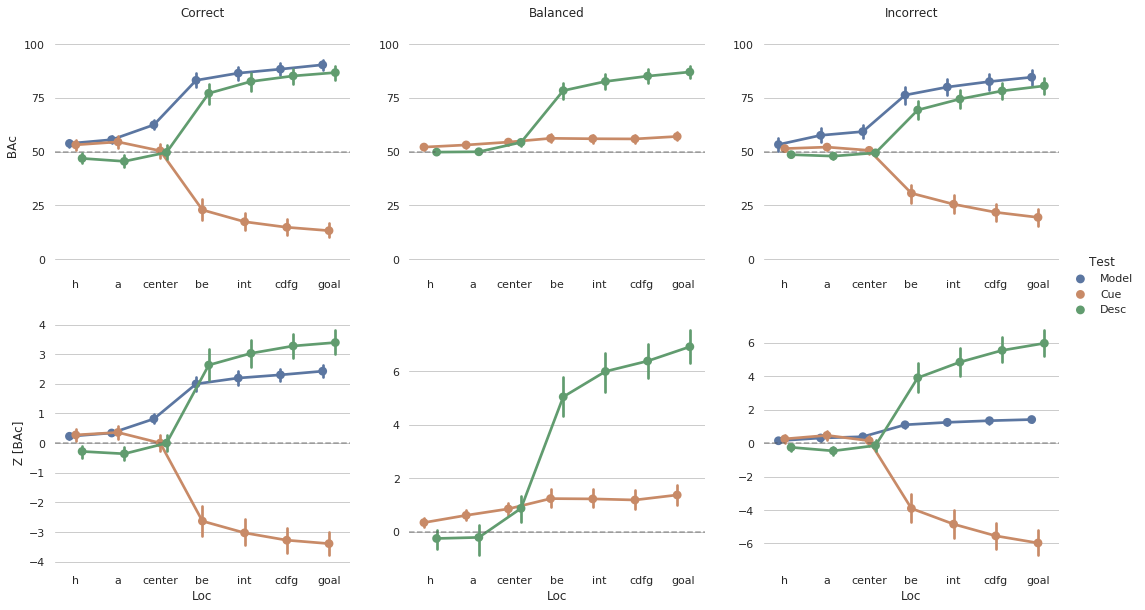

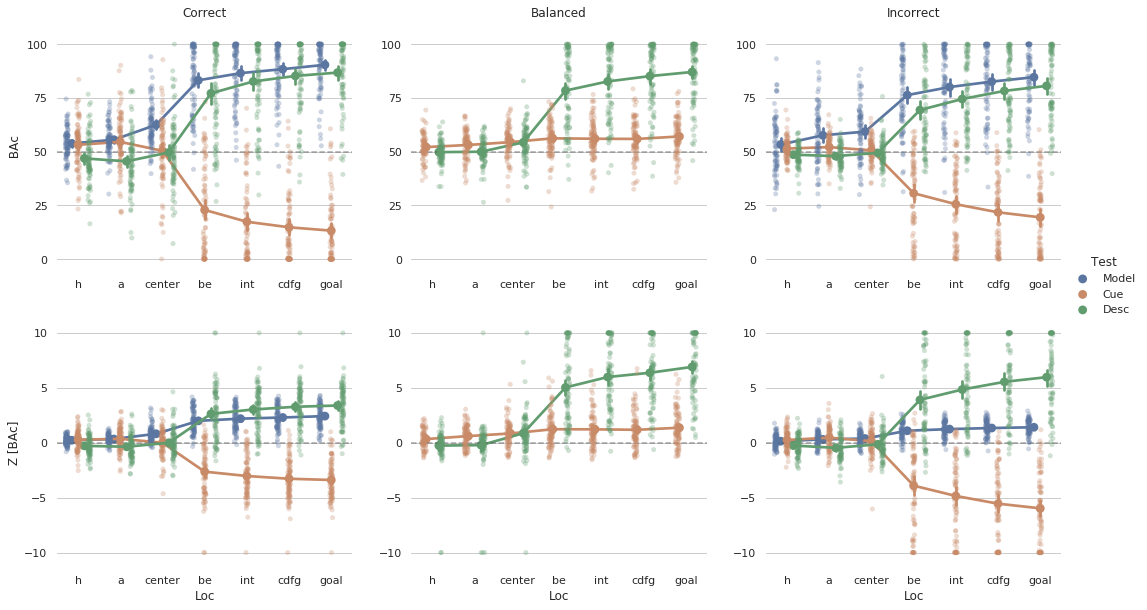

In [119]:
relevant_vars = ['Loc','Test','unit','Decoder','BAc','P','Z','-log(P)','se','an','nTrials', 'pCo', 'pCoST', 'uID']

X = All_PopSumDecRes.copy()
X.loc[X['Z']>10,'Z']=10
X.loc[X['Z']<-10,'Z']=-10


_=SBA.plotMultipleDecoderResults(X,plotAll=False,ci=95)
_=SBA.plotMultipleDecoderResults(X,plotAll=True,ci=95)


## III. Identifying cells based on their decoding patterns.


In [560]:
relevant_vars = ['Loc','Test','unit','Decoder','BAc','P','Z','-log(P)','se','an','nTrials', 'pCo', 'pCoST', 'uID']
X = All_DecRes[relevant_vars].copy()
X.groupby(['Test','Loc','Decoder','an','se']).mean()
X=X.reset_index()
X['Test'] = pd.Categorical(X['Test'],categories=['Model','Cue','Desc'],ordered=True)
X.sort_values('Test',inplace=True)
X['Loc'] = pd.Categorical(X['Loc'],categories=['h','a','center','be','int','cdfg','goal'],ordered=True)
X.sort_values('Loc',inplace=True)

X.loc[X['Z']>10,'Z']=10
X.loc[X['Z']<-10,'Z']=-10

### corrrect model

number of units showing Cue coding in segment a: 20 / 873 = 0.023
number of units showing Cue coding in segment cdfg: 1 / 873 = 0.001
number of units showing Desc coding in segment a: 21 / 873 = 0.024
number of units showing Desc coding in segment cdfg: 255 / 872 = 0.292
Relationship to Univariate Results


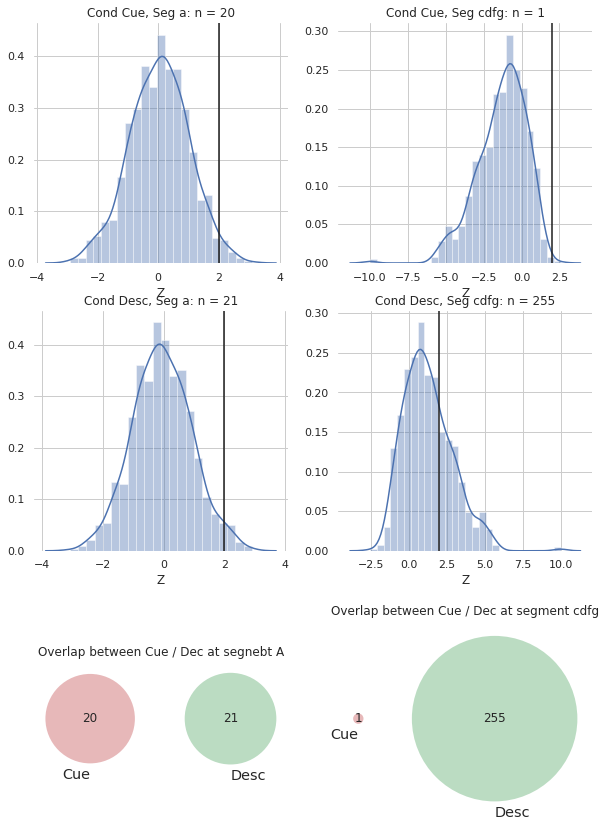

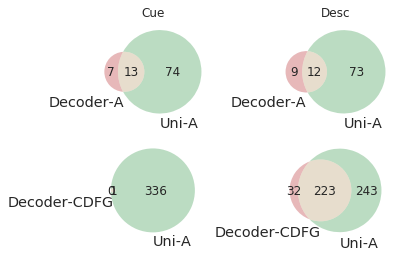

In [572]:

model = 'Correct'
subset = (X['Decoder']==model) 
Y = X[subset].copy()
Y = Y[~Y['Z'].isnull()]

thr = 2
Segs = ['a','cdfg']
Conds = ['Cue','Desc']

DecCellSets = {}

f,ax = plt.subplots(3,2,figsize=(10,15))
ax=ax.flatten()
cnt=0
for cond in Conds:
    DecCellSets[cond] = {}
    for s in Segs:
        subset = (Y['Loc']==s) & (Y['Test']==cond)

        ax[cnt]=sns.distplot(Y[subset]['Z'],ax=ax[cnt])

        #ax[cnt].axvline(-thr,color='k')
        ax[cnt].axvline(thr,color='k')

        x= Y[subset]['Z']>thr
        DecCellSets[cond][s] = set(Y[subset]['uID'][x].values)
        ax[cnt].set_title('Cond {}, Seg {}: n = {}'.format(cond,s,np.sum(x)))

        print( 'number of units showing {0} coding in segment {1}: {2} / {3} = {4:.3f}'.format(cond,s,np.sum(x),len(x),np.mean(x)))
        cnt+=1
    
plt.sca(ax[4])
ax[4].set_title('Overlap between Cue / Dec at segnebt A')
#_=venn3([ CellSets[cond]['A'], CellSets[cond]['Stem']],set_labels=Segs)
_=venn2([DecCellSets['Cue']['a'],DecCellSets['Desc']['a']],set_labels=['Cue','Desc'])
plt.sca(ax[5])
_=venn2([DecCellSets['Cue']['cdfg'],DecCellSets['Desc']['cdfg']],set_labels=['Cue','Desc'])
ax[5].set_title('Overlap between Cue / Dec at segment cdfg')


f,ax=plt.subplots(2,2)
ax = ax.flatten()
plt.sca(ax[0])
_=venn2([DecCellSets['Cue']['a'],UniCellSets['Cue']['A']],set_labels=['Decoder-A','Uni-A'])
ax[0].set_title('Cue')

plt.sca(ax[1])
_=venn2([DecCellSets['Desc']['a'],UniCellSets['Desc']['A']],['Decoder-A','Uni-A'])
ax[1].set_title('Desc')

plt.sca(ax[2])
_=venn2([DecCellSets['Cue']['cdfg'],UniCellSets['Cue']['Arm']],['Decoder-CDFG','Uni-A'])

plt.sca(ax[3])
_=venn2([DecCellSets['Desc']['cdfg'],UniCellSets['Desc']['Arm']],['Decoder-CDFG','Uni-A'])
print('Relationship to Univariate Results')

number of units showing Cue coding in segment a: 20 / 920 = 0.022
number of units showing Cue coding in segment cdfg: 128 / 920 = 0.139
number of units showing Desc coding in segment a: 17 / 913 = 0.019
number of units showing Desc coding in segment cdfg: 422 / 910 = 0.464
Relationship to Univariate Results


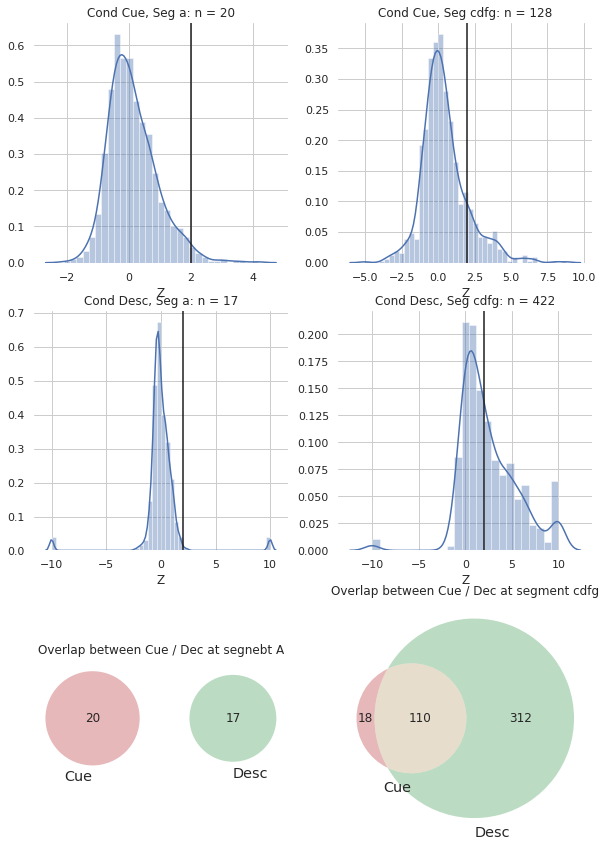

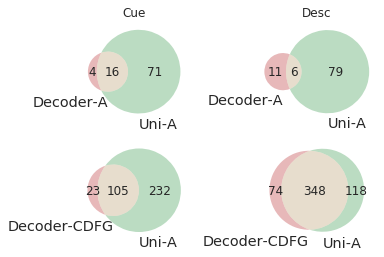

In [573]:
model = 'Balanced'
subset = (X['Decoder']==model) 
Y = X[subset].copy()
Y = Y[~Y['Z'].isnull()]

thr = 2
Segs = ['a','cdfg']
Conds = ['Cue','Desc']

DecCellSets = {}

f,ax = plt.subplots(3,2,figsize=(10,15))
ax=ax.flatten()
cnt=0
for cond in Conds:
    DecCellSets[cond] = {}
    for s in Segs:
        subset = (Y['Loc']==s) & (Y['Test']==cond)

        ax[cnt]=sns.distplot(Y[subset]['Z'],ax=ax[cnt])

        #ax[cnt].axvline(-thr,color='k')
        ax[cnt].axvline(thr,color='k')

        x= Y[subset]['Z']>thr
        DecCellSets[cond][s] = set(Y[subset]['uID'][x].values)
        ax[cnt].set_title('Cond {}, Seg {}: n = {}'.format(cond,s,np.sum(x)))

        print( 'number of units showing {0} coding in segment {1}: {2} / {3} = {4:.3f}'.format(cond,s,np.sum(x),len(x),np.mean(x)))
        cnt+=1
    
plt.sca(ax[4])
ax[4].set_title('Overlap between Cue / Dec at segnebt A')
#_=venn3([ CellSets[cond]['A'], CellSets[cond]['Stem']],set_labels=Segs)
_=venn2([DecCellSets['Cue']['a'],DecCellSets['Desc']['a']],set_labels=['Cue','Desc'])
plt.sca(ax[5])
_=venn2([DecCellSets['Cue']['cdfg'],DecCellSets['Desc']['cdfg']],set_labels=['Cue','Desc'])
ax[5].set_title('Overlap between Cue / Dec at segment cdfg')

f,ax=plt.subplots(2,2)
ax = ax.flatten()
plt.sca(ax[0])
_=venn2([DecCellSets['Cue']['a'],UniCellSets['Cue']['A']],set_labels=['Decoder-A','Uni-A'])
ax[0].set_title('Cue')

plt.sca(ax[1])
_=venn2([DecCellSets['Desc']['a'],UniCellSets['Desc']['A']],['Decoder-A','Uni-A'])
ax[1].set_title('Desc')

plt.sca(ax[2])
_=venn2([DecCellSets['Cue']['cdfg'],UniCellSets['Cue']['Arm']],['Decoder-CDFG','Uni-A'])

plt.sca(ax[3])
_=venn2([DecCellSets['Desc']['cdfg'],UniCellSets['Desc']['Arm']],['Decoder-CDFG','Uni-A'])
print('Relationship to Univariate Results')

In [576]:
DecCellSets['Cue']['a']

{51,
 90,
 159,
 181,
 187,
 276,
 278,
 370,
 499,
 571,
 579,
 784,
 800,
 808,
 813,
 818,
 886,
 898,
 905,
 910}

In [607]:
XX=All_DecRes.groupby(['an','se','uID']).mean()
XX = XX.reset_index()
XX=XX.set_index('uID')

#sets = DecCellSets['Desc']['a']
sets = UniCellSets['Desc']['Arm']
counts =  XX.loc[sets]['an'].value_counts()
totals = XX['an'].value_counts()
ratios = counts/totals
pd.DataFrame([counts,ratios,totals],index=['counts','ratio','totals']).T

,counts,ratio,totals
Li,233.0,0.495745,470.0
Ne,129.0,0.470803,274.0
Cl,104.0,0.559140,186.0


Li    470
Ne    274
Cl    186
Name: an, dtype: int64

In [227]:
BAc=X.set_index('uID').pivot_table(index='uID',columns=['Decoder','Test','Loc'],values='BAc',aggfunc='mean')
Z=X.set_index('uID').pivot_table(index='uID',columns=['Decoder','Test','Loc'],values='Z',aggfunc='mean')
goodCells = np.isnan(Z.values).sum(axis=1)==0
BAc = BAc[goodCells]
Z = Z[goodCells]

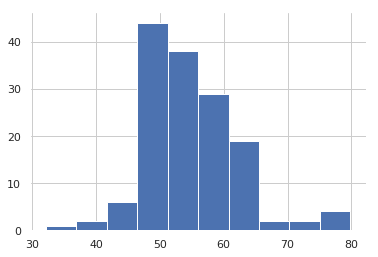

In [247]:
mod = 'Balanced'
loc = 'goal'
c = 'Cue'
subset = Z.loc[:,(mod,c,loc)]>2
_=plt.hist(BAc.loc[subset,('Balanced','Cue','center')])


In [275]:
subset = (X['Decoder']=='Incorrect')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = X[subset]
dat = dat[~dat['Z'].isnull()]

tol = 0.001
f = lambda x: np.log( (x+tol) /(1- (x+tol)))
dat['L_pCo'] =  f(dat['pCo'])

md =smf.mixedlm('L_pCo ~  Z+Test + Z:Test:Loc  ',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     L_pCo     
No. Observations:      16507       Method:                 REML      
No. Groups:            3           Scale:                  0.1513    
Min. group size:       3541        Likelihood:             -7922.9949
Max. group size:       9281        Converged:              Yes       
Mean group size:       5502.3                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.524    0.106 14.418 0.000  1.316  1.731
Test[T.Cue]                -0.015    0.008 -1.864 0.062 -0.032  0.001
Test[T.Desc]               -0.015    0.008 -1.864 0.062 -0.032  0.001
Z                          -0.009    0.024 -0.373 0.709 -0.056  0.038
Z:Loc[T.a]                 -0.005   

In [529]:
13*20


260

In [155]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [219]:
ypca = PCA(n_components=5).fit_transform(Y[goodCells].T)

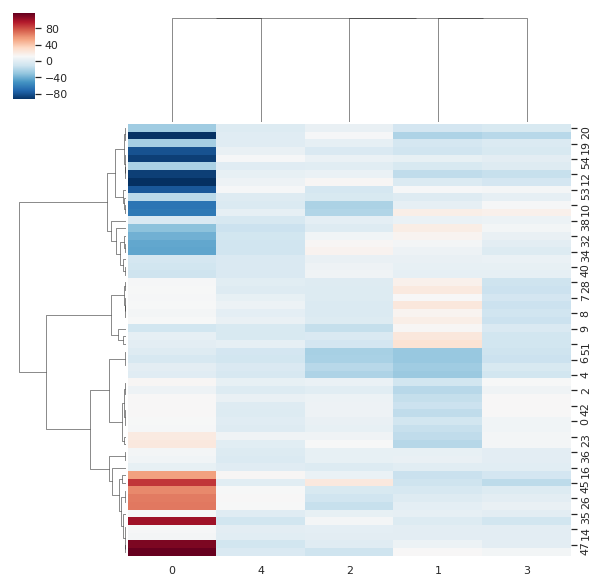

In [220]:
#sns.clustermap(Y.corr(),metric='correlation',cmap = 'RdBu_r')
sns.clustermap(ypca,metric='correlation',cmap = 'RdBu_r')

In [280]:
pCo[goodCells].shape

(769,)

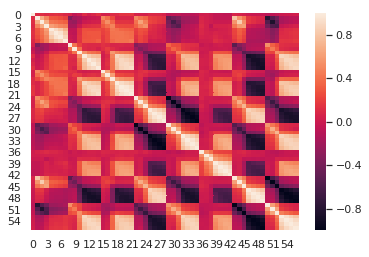

In [287]:
sns.heatmap(np.corrcoef(pCo[goodCells],Z.values.T))

## IV. Population Relationship to Session Accuracy.

In [373]:
tol = 0.001
pCo = All_PopSumDecRes.groupby('se').mean()['pCo']
pCoST = All_PopSumDecRes.groupby('se').mean()['pCoST']
C = pd.DataFrame()
CS = pd.DataFrame()

f = lambda x: np.log( (x+tol) /(1- (x+tol)))

xxxx = All_PopSumDecRes.set_index('se').pivot_table(index='se',columns=['Decoder','Test','Loc'],values='BAc',aggfunc='mean')
xxxx = xxxx.T.reindex(['h','a','center','be','int','cdfg','goal'],level='Loc').T
xxxx['pCo'] = f(pCo)
xxxx['pCoST'] = f(pCoST)
C['BAc'] = xxxx.corr(method='spearman')['pCo']
CS['BAc'] = xxxx.corr(method='spearman')['pCoST']


xxxx['pCoST'] = f(pCoST)

xxxx = All_PopSumDecRes.set_index('se').pivot_table(index='se',columns=['Decoder','Test','Loc'],values='Z',aggfunc='mean')
xxxx = xxxx.T.reindex(['h','a','center','be','int','cdfg','goal'],level='Loc').T
xxxx['pCo'] = f(pCo)
xxxx['pCoST'] = f(pCoST)
C['Z'] = xxxx.corr(method='spearman')['pCo']
CS['Z'] = xxxx.corr(method='spearman')['pCoST']


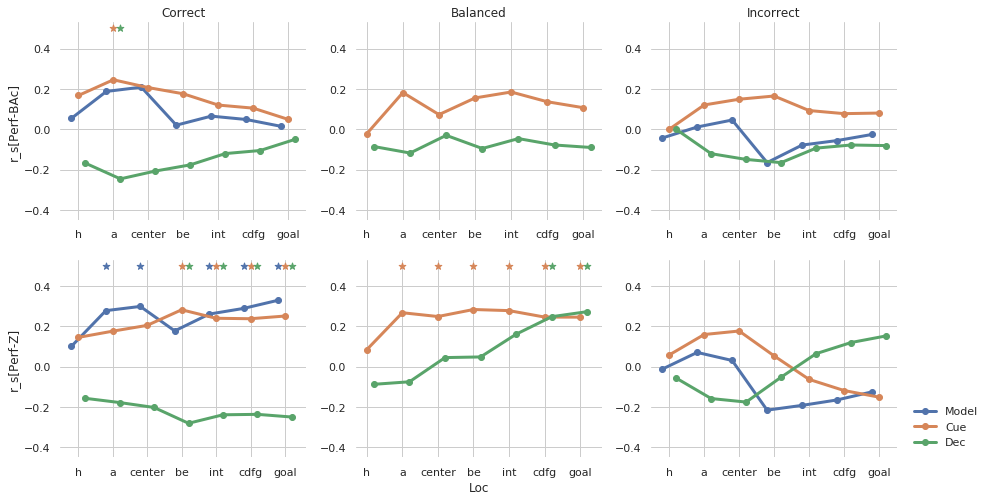

In [422]:
pal =sns.color_palette(desat=.9)[:3]
f,ax = plt.subplots(2,3,figsize=(15,8))
lw =3
n = len(pCoST)
P = np.abs(np.arctanh(C)*np.sqrt((n-3)/1.06))>2
x=np.arange(7)
locs = ['h','a','center','be','int','cdfg','goal']
ii = 0
for tt in ['BAc','Z']:
    jj = 0
        
    for model in ['Correct','Balanced','Incorrect']:
        if model!='Balanced':
            ax[ii,jj].plot(x-0.2,C.loc[(model,'Model'),tt],color=pal[0],label = 'Model',linewidth=lw,marker = 'o')
            cnt=0
            for i in P.loc[(model,'Model'),tt]:
                if i:
                    ax[ii,jj].scatter(cnt-0.2,0.5,50,marker='*',color=pal[0])
                cnt+=1
        # Cue   
        ax[ii,jj].plot(x,C.loc[(model,'Cue'),tt],color=pal[1],label = 'Cue',linewidth=lw,marker = 'o')
        cnt=0
        for i in P.loc[(model,'Cue'),tt]:
            if i:
                ax[ii,jj].scatter(cnt,0.5,50,marker='*',color=pal[1])
            cnt+=1
        
        # Dec
        ax[ii,jj].plot(x+0.2,C.loc[(model,'Desc'),tt],color=pal[2],label = 'Dec',linewidth=lw,marker = 'o')
        cnt=0
        for i in P.loc[(model,'Desc'),tt]:
            if i:
                ax[ii,jj].scatter(cnt+0.2,0.5,50,marker='*',color=pal[2])
            cnt+=1
            
        ax[ii,jj].set_ylim([-0.45,0.53])
        if ii==0:
            ax[ii,jj].set_title(model)
        jj+=1
        
        ax[ii,0].set_ylabel('r_s[Perf-{}]'.format(tt))
    ii+=1
for ii in np.arange(2):
    for jj in np.arange(3):
        ax[ii,jj].set_xticks(x)
        ax[ii,jj].set_xticklabels(locs)
ax[1,1].set_xlabel('Loc')
ax[1,2].legend(labels = ['Model','Cue','Dec'],loc=3,bbox_to_anchor=[1.03,0],frameon=False)

### Stats on correct model

In [494]:
f = lambda x: np.log( (x+tol) /(1- (x+tol)))

subset = (All_PopSumDecRes['Decoder']=='Correct') &(All_PopSumDecRes['Test']=='Cue')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_PopSumDecRes[subset].copy()#All_PopSumDecRes[subset]

dat['L_BAc'] = f(dat['BAc']/100)
dat['L_pCo'] =  f(dat['pCo'])
dat.loc[dat['Z']>10,'Z'] =10
dat.loc[dat['Z']<-10,'Z'] = -10

dat = dat[~dat['L_BAc'].isnull()]
dat = dat[~dat['L_pCo'].isnull()]

md =smf.mixedlm('L_pCo ~ Loc:L_BAc+L_BAc',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

print('\n\n')
dat = dat[~dat['Z'].isnull()]
md =smf.mixedlm('L_pCo ~ Loc:Z+Z',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   L_pCo    
No. Observations:    574       Method:               REML     
No. Groups:          3         Scale:                0.1529   
Min. group size:     140       Likelihood:           -298.4557
Max. group size:     245       Converged:            Yes      
Mean group size:     191.3                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            1.507    0.137 10.960 0.000  1.237  1.776
L_BAc                0.124    0.070  1.784 0.074 -0.012  0.261
Loc[T.be]:L_BAc     -0.123    0.071 -1.715 0.086 -0.263  0.017
Loc[T.cdfg]:L_BAc   -0.124    0.071 -1.747 0.081 -0.263  0.015
Loc[T.center]:L_BAc -0.128    0.081 -1.579 0.114 -0.287  0.031
Loc[T.goal]:L_BAc   -0.128    0.071 -1.802 0.072 -0.267  0.011
Loc[T

### stats on balanced model

In [496]:

subset = (All_PopSumDecRes['Decoder']=='Balanced') 
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_PopSumDecRes[subset].copy()#All_PopSumDecRes[subset]

dat['L_BAc'] = f(dat['BAc']/100)
dat['L_pCo'] =  f(dat['pCo'])
dat.loc[dat['Z']>10,'Z'] =10
dat.loc[dat['Z']<-10,'Z'] = -10

dat = dat[~dat['L_BAc'].isnull()]
dat = dat[~dat['L_pCo'].isnull()]

md =smf.mixedlm('L_pCo ~ Loc:L_BAc+L_BAc*Test',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

print('\n\n')
dat = dat[~dat['Z'].isnull()]
md =smf.mixedlm('L_pCo ~ Loc:Z+Z*Test',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   L_pCo    
No. Observations:    1145      Method:               REML     
No. Groups:          3         Scale:                0.1509   
Min. group size:     290       Likelihood:           -567.2693
Max. group size:     485       Converged:            Yes      
Mean group size:     381.7                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            1.485    0.143 10.382 0.000  1.205  1.766
Test[T.Desc]         0.015    0.028  0.544 0.586 -0.040  0.070
L_BAc                0.142    0.118  1.206 0.228 -0.089  0.372
Loc[T.be]:L_BAc     -0.035    0.117 -0.302 0.763 -0.266  0.195
Loc[T.cdfg]:L_BAc   -0.041    0.117 -0.350 0.726 -0.271  0.189
Loc[T.center]:L_BAc  0.054    0.140  0.388 0.698 -0.220  0.329
Loc[T

### switch performance.

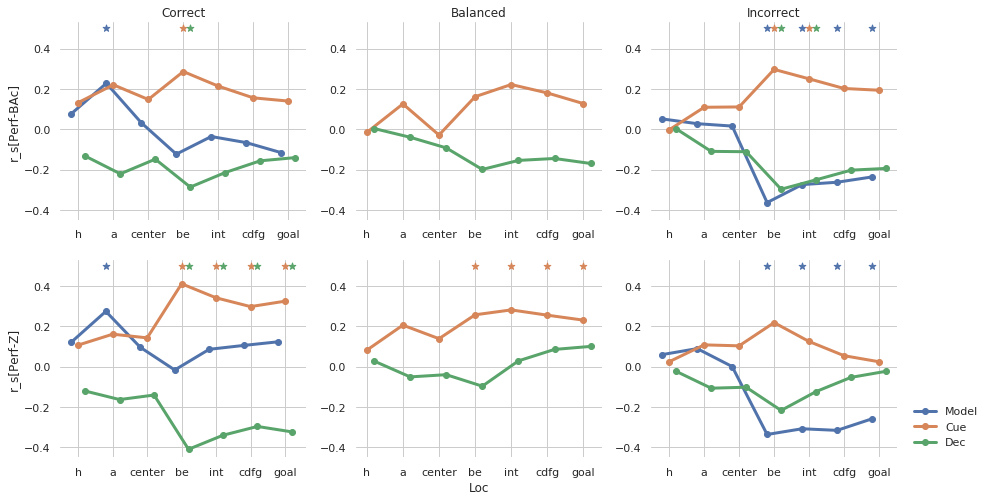

In [421]:
pal =sns.color_palette(desat=.9)[:3]
f,ax = plt.subplots(2,3,figsize=(15,8))
lw =3
n = len(pCoST)
P = np.abs(np.arctanh(CS)*np.sqrt((n-3)/1.06))>2
x=np.arange(7)
locs = ['h','a','center','be','int','cdfg','goal']
ii = 0
for tt in ['BAc','Z']:
    jj = 0
        
    for model in ['Correct','Balanced','Incorrect']:
        if model!='Balanced':
            ax[ii,jj].plot(x-0.2,CS.loc[(model,'Model'),tt],color=pal[0],label = 'Model',linewidth=lw,marker = 'o')
            cnt=0
            for i in P.loc[(model,'Model'),tt]:
                if i:
                    ax[ii,jj].scatter(cnt-0.2,0.5,50,marker='*',color=pal[0])
                cnt+=1
        # Cue   
        ax[ii,jj].plot(x,CS.loc[(model,'Cue'),tt],color=pal[1],label = 'Cue',linewidth=lw,marker = 'o')
        cnt=0
        for i in P.loc[(model,'Cue'),tt]:
            if i:
                ax[ii,jj].scatter(cnt,0.5,50,marker='*',color=pal[1])
            cnt+=1
        
        # Dec
        ax[ii,jj].plot(x+0.2,CS.loc[(model,'Desc'),tt],color=pal[2],label = 'Dec',linewidth=lw,marker = 'o')
        cnt=0
        for i in P.loc[(model,'Desc'),tt]:
            if i:
                ax[ii,jj].scatter(cnt+0.2,0.5,50,marker='*',color=pal[2])
            cnt+=1
            
        ax[ii,jj].set_ylim([-0.45,0.53])
        if ii==0:
            ax[ii,jj].set_title(model)
        jj+=1
        
        ax[ii,0].set_ylabel('r_s[Perf-{}]'.format(tt))
    ii+=1
for ii in np.arange(2):
    for jj in np.arange(3):
        ax[ii,jj].set_xticks(x)
        ax[ii,jj].set_xticklabels(locs)
ax[1,1].set_xlabel('Loc')
ax[1,2].legend(labels = ['Model','Cue','Dec'],loc=3,bbox_to_anchor=[1.03,0],frameon=False)

### stats on correct model

In [497]:
f = lambda x: np.log( (x+tol) /(1- (x+tol)))

subset = (All_PopSumDecRes['Decoder']=='Correct') &(All_PopSumDecRes['Test']=='Cue')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_PopSumDecRes[subset].copy()#All_PopSumDecRes[subset]

dat['L_BAc'] = f(dat['BAc']/100)
dat['L_pCoST'] =  f(dat['pCoST'])
dat.loc[dat['Z']>10,'Z'] =10
dat.loc[dat['Z']<-10,'Z'] = -10

dat = dat[~dat['L_BAc'].isnull()]
dat = dat[~dat['L_pCoST'].isnull()]

md =smf.mixedlm('L_pCoST ~ Loc:L_BAc+L_BAc',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

print('\n\n')
dat = dat[~dat['Z'].isnull()]
md =smf.mixedlm('L_pCoST ~ Loc:Z+Z',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())



            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   L_pCoST  
No. Observations:    574       Method:               REML     
No. Groups:          3         Scale:                0.3000   
Min. group size:     140       Likelihood:           -490.1185
Max. group size:     245       Converged:            Yes      
Mean group size:     191.3                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            1.950    0.291  6.691 0.000  1.378  2.521
L_BAc                0.161    0.098  1.650 0.099 -0.030  0.352
Loc[T.be]:L_BAc     -0.163    0.100 -1.631 0.103 -0.359  0.033
Loc[T.cdfg]:L_BAc   -0.163    0.100 -1.638 0.101 -0.358  0.032
Loc[T.center]:L_BAc -0.152    0.114 -1.340 0.180 -0.375  0.071
Loc[T.goal]:L_BAc   -0.166    0.099 -1.672 0.095 -0.361  0.029
Loc[T

### stats on balanced model

In [498]:

subset = (All_PopSumDecRes['Decoder']=='Balanced') 
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_PopSumDecRes[subset].copy()#All_PopSumDecRes[subset]

dat['L_BAc'] = f(dat['BAc']/100)
dat['L_pCoST'] =  f(dat['pCo'])
dat.loc[dat['Z']>10,'Z'] =10
dat.loc[dat['Z']<-10,'Z'] = -10

dat = dat[~dat['L_BAc'].isnull()]
dat = dat[~dat['L_pCoST'].isnull()]

md =smf.mixedlm('L_pCoST ~ Loc:L_BAc+L_BAc*Test',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

print('\n\n')
dat = dat[~dat['Z'].isnull()]
md =smf.mixedlm('L_pCoST ~ Loc:Z+Z*Test',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   L_pCoST  
No. Observations:    1145      Method:               REML     
No. Groups:          3         Scale:                0.1509   
Min. group size:     290       Likelihood:           -567.2693
Max. group size:     485       Converged:            Yes      
Mean group size:     381.7                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            1.485    0.143 10.382 0.000  1.205  1.766
Test[T.Desc]         0.015    0.028  0.544 0.586 -0.040  0.070
L_BAc                0.142    0.118  1.206 0.228 -0.089  0.372
Loc[T.be]:L_BAc     -0.035    0.117 -0.302 0.763 -0.266  0.195
Loc[T.cdfg]:L_BAc   -0.041    0.117 -0.350 0.726 -0.271  0.189
Loc[T.center]:L_BAc  0.054    0.140  0.388 0.698 -0.220  0.329
Loc[T